In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


I0119 102812.999 _utils_internal.py:231] NCCL_DEBUG env var is set to None


I0119 102813.000 _utils_internal.py:249] NCCL_DEBUG is forced to WARN from None


I0119 102815.044 font_manager.py:1349] generated new fontManager


In [3]:
words = open("/home/yucongguo/names.txt","r").read().splitlines()
print(f"length of words: {len(words)}")

length of words: 32033


In [4]:
# build the vocabulary of characters and mapping to/from integers
char = sorted(list(set(''.join(words))))
str_to_int = {string: index+1 for index, string in enumerate(char)}
str_to_int['.'] = 0
int_to_str = {index+1: string for index, string in enumerate(char)}
int_to_str[0] = '.'
print(f"str_to_int : {str_to_int}")
print(f"int_to_str : {int_to_str}")

str_to_int : {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
int_to_str : {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 #context length: how many characters do we take to predict the next one
X = []
Y = []
count = 0
for w in words:

    # example of first word
    if count == 0:
        print(w)

    context = [0] * 3  #start with '...'
    for character in w + '.':
        index = str_to_int[character]
        X.append(context)
        Y.append(index)

        if count == 0:
            print(''.join(int_to_str[i] for i in context) ,"--->",int_to_str[index])

        # crop and append
        context = context[1:] + [index]

       
    count += 1

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .


In [6]:
print(f"X.shape = {X.shape}")
print(X[:3])
print(f"X.dtype = {X.dtype}")
print(f"\nY.dtype = {Y.dtype}")
print(Y[:3])
print(f"Y.dtype = {Y.dtype}")


X.shape = torch.Size([228146, 3])
tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13]])
X.dtype = torch.int64

Y.dtype = torch.int64
tensor([ 5, 13, 13])
Y.dtype = torch.int64


Word Embedding is really all about improving the ability of networks to learn from text data. By representing that data as lower dimensional vectors. These vectors are called Embedding.

In [7]:
# show how embedding works

C=torch.rand((6,2) ) #define the embedding layer with 6 vocab size and 2 vector embedding
print(C)
print(X[0:2])
print(C[X[0:2]])

tensor([[0.8850, 0.4044],
        [0.5379, 0.6393],
        [0.2329, 0.6151],
        [0.3282, 0.7715],
        [0.1756, 0.1759],
        [0.5429, 0.3499]])
tensor([[0, 0, 0],
        [0, 0, 5]])
tensor([[[0.8850, 0.4044],
         [0.8850, 0.4044],
         [0.8850, 0.4044]],

        [[0.8850, 0.4044],
         [0.8850, 0.4044],
         [0.5429, 0.3499]]])


In [8]:
# define actual embedding layer

C = torch.rand((27,2)) #define the embedding layer with 27 vocab size and 2 vector embedding
emb = C[X]

print(f"X.shape = {X.shape}")
print(f"emb.shape = {emb.shape}")
print("emb size: 228146 data, each data use 3 character to predict next one, also each character has 2 vector embedding")

X.shape = torch.Size([228146, 3])
emb.shape = torch.Size([228146, 3, 2])
emb size: 228146 data, each data use 3 character to predict next one, also each character has 2 vector embedding


In [9]:
# model: input layer 6, hidden layer:100, output layer: 27

#define parameter from input layer to hidden layer
w1 = torch.randn((6,100))
b1 = torch.randn(100)

#reshape emb since emb size is (228146,3,2)
emb_reshape = emb.view(-1,6)  #same as emb.view(emb.shape[0],6)

hidden = torch.tanh(emb_reshape @ w1 + b1 )

#output layer
w2 = torch.randn(100,27)
b2 = torch.randn(27)
out = hidden @ w2 + b2

#get the loss: softmax and negative log likelihood = cross entropy
counts = out.exp()
prob = counts / counts.sum(1,keepdims = True) #prob.shape: 228146,27
loss = -prob[torch.arange(len(X)),Y].log().mean()
print(f"initial loss: {loss}")

initial loss: 14.145712852478027


In [12]:
# note that softmax and negative log likelihood is the cross entropy loss

#soft max + nll
counts = out.exp()
prob = counts / counts.sum(1,keepdims = True) #prob.shape: 228146,27
loss = -prob[torch.arange(len(X)),Y].log().mean()
print(f"softmax + nll loss = {loss}")

# torch cross entropy loss
loss = F.cross_entropy(out,Y)
print(f"cross entropy loss = {loss}")

softmax + nll loss = 14.145712852478027
cross entropy loss = 14.145709991455078


## train multi layer NN model

In [22]:
# split data
# training data: used to train the model  80% 
# validation data: used for development over all the hyper parameter of the model.  10%
# testing data: validate performance of the model.  10%

import random
random.seed(42)
random.shuffle(words)

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

x_train = X[:n1]
x_val = X[n1:n2]
x_test = X[n2:]

y_train = Y[:n1]
y_val = Y[n1:n2]
y_test = Y[n2:]

In [55]:
# define parameter

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g, requires_grad=True)
w1 = torch.randn((6,100), generator = g, requires_grad=True)
b1 = torch.randn(100, generator = g, requires_grad=True)
w2 = torch.randn((100,27), generator = g, requires_grad=True)
b2 = torch.randn(27, generator = g, requires_grad=True)



 note at at -1, the graph is stable. therefore, learning rate is good at 10 ** -1 = 0.1


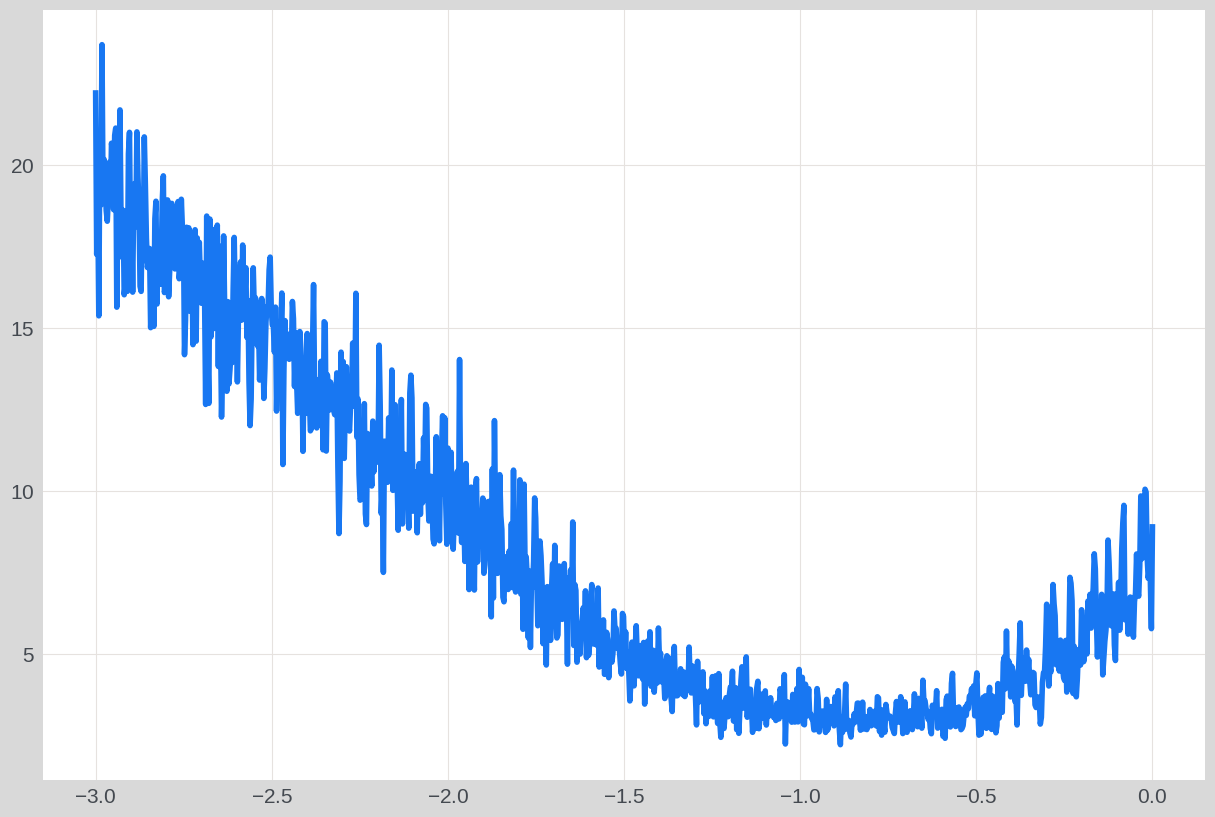

In [57]:
# find the learning rate


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g, requires_grad=True)
w1 = torch.randn((6,100), generator = g, requires_grad=True)
b1 = torch.randn(100, generator = g, requires_grad=True)
w2 = torch.randn((100,27), generator = g, requires_grad=True)
b2 = torch.randn(27, generator = g, requires_grad=True)

learning_rate_exp = torch.linspace(-3,0,1000)
learing_rate = 10 ** learning_rate_exp #exponential distributed
loss_list = []
learning_rate_list = []

for i in range(1000):

    #minibatch : each minibatch has 32 data
    ix = torch.randint(0, x_train.shape[0], (32,))

    #forward pass
    emb = C[x_train[ix]] # (32,3,2)
    hidden = torch.tanh(emb.view(-1,6) @ w1 + b1)
    out = hidden @ w2 + b2
    loss = F.cross_entropy(out, y_train[ix])

    #barkward pass
    parameters = [C, w1, b1, w2, b2]
    for p in parameters: 
        p.grad = None #set grad = 0, because by default, gradients are accumulated in buffers (i.e, not overwritten) whenever .backward() is called.
    loss.backward()

    #update
    lr = learing_rate[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track loss
    loss_list.append(loss.item())
    learning_rate_list.append(learning_rate_exp[i])
plt.plot(learning_rate_list,loss_list)
print("\n note at at -1, the graph is stable. therefore, learning rate is good at 10 ** -1 = 0.1")

training loss = 2.293583869934082
validation loss = 2.3765981197357178


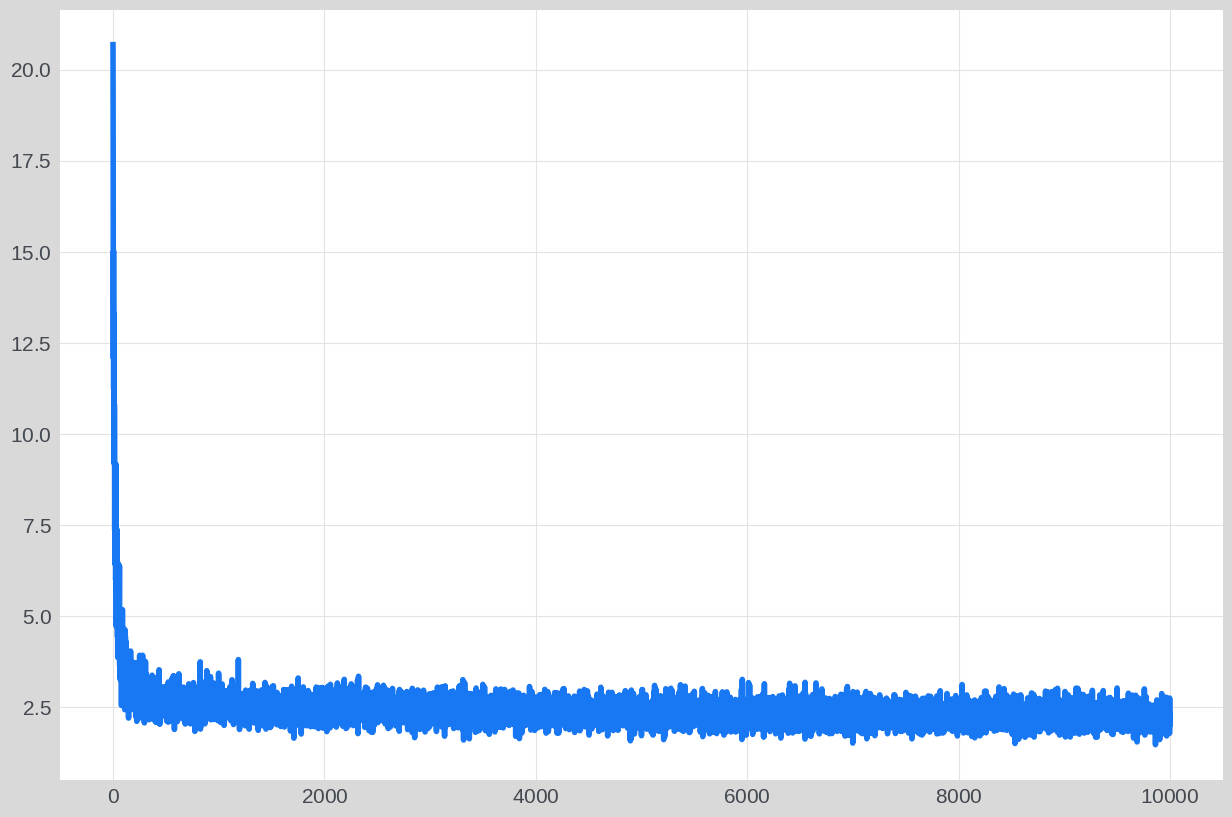

In [69]:
# train the model using minibatch GD

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g, requires_grad=True)
w1 = torch.randn((6,100), generator = g, requires_grad=True)
b1 = torch.randn(100, generator = g, requires_grad=True)
w2 = torch.randn((100,27), generator = g, requires_grad=True)
b2 = torch.randn(27, generator = g, requires_grad=True)

loss_i = []
step_i = []

for i in range(10000):


    #minibatch : each minibatch has 32 data
    ix = torch.randint(0, x_train.shape[0], (32,))

    #forward pass
    emb = C[x_train[ix]] # (32,3,2)
    hidden = torch.tanh(emb.view(-1,6) @ w1 + b1)
    out = hidden @ w2 + b2
    loss = F.cross_entropy(out, y_train[ix])

    #barkward pass
    learn_rate = 0.1 if i>10000 else 0.01
    parameters = [C, w1, b1, w2, b2]
    for p in parameters: 
        p.grad = None #set grad = 0, because by default, gradients are accumulated in buffers (i.e, not overwritten) whenever .backward() is called.
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 * p.grad

    step_i.append(i)
    loss_i.append(loss)

# traning loss
emb = C[x_train] 
hidden = torch.tanh(emb.view(-1,6) @ w1 + b1)
out = hidden @ w2 + b2
loss = F.cross_entropy(out, y_train)
print(f"training loss = {loss}" )

# validation loss
emb = C[x_val] # 
hidden = torch.tanh(emb.view(-1,6) @ w1 + b1)
out = hidden @ w2 + b2
loss = F.cross_entropy(out, y_val)
print(f"validation loss = {loss}" )

plt.plot(step_i,loss_i)

In [68]:
# use validation test set to determin the hyper parameter 

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator = g, requires_grad=True)
w1 = torch.randn((30,200), generator = g, requires_grad=True)
b1 = torch.randn(200, generator = g, requires_grad=True)
w2 = torch.randn((200,27), generator = g, requires_grad=True)
b2 = torch.randn(27, generator = g, requires_grad=True)

loss_i = []
step_i = []

for i in range(40000):


    #minibatch : each minibatch has 32 data
    ix = torch.randint(0, x_train.shape[0], (32,))

    #forward pass
    emb = C[x_train[ix]] # (32,3,10)
    hidden = torch.tanh(emb.view(-1,30) @ w1 + b1) #(32,200)
    out = hidden @ w2 + b2 #(32,27)
    loss = F.cross_entropy(out, y_train[ix])

    #barkward pass
    learn_rate = 0.1 if i>10000 else 0.01
    parameters = [C, w1, b1, w2, b2]
    for p in parameters: 
        p.grad = None #set grad = 0, because by default, gradients are accumulated in buffers (i.e, not overwritten) whenever .backward() is called.
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 * p.grad

    step_i.append(i)
    loss_i.append(loss)

# traning loss
emb = C[x_train] 
hidden = torch.tanh(emb.view(-1,30) @ w1 + b1)
out = hidden @ w2 + b2
loss = F.cross_entropy(out, y_train)
print(f"training loss = {loss}" )

# validation loss
emb = C[x_val] # 
hidden = torch.tanh(emb.view(-1,30) @ w1 + b1)
out = hidden @ w2 + b2
loss = F.cross_entropy(out, y_val)
print(f"validation loss = {loss}" )

#plt.plot(step_i,loss_i)

training loss = 1.8366817235946655
validation loss = 2.37345290184021


note that second hyperparameter give us lower validation loss. \
use the following multi layer peceptron model:
C: (27,10)
input layer 3*10 neural
hidden layer : 100 neural

note that aeio are relative close to each other which means embedded layer treat them similar
note that g are relative far away  which means embedded layer treat it completely different




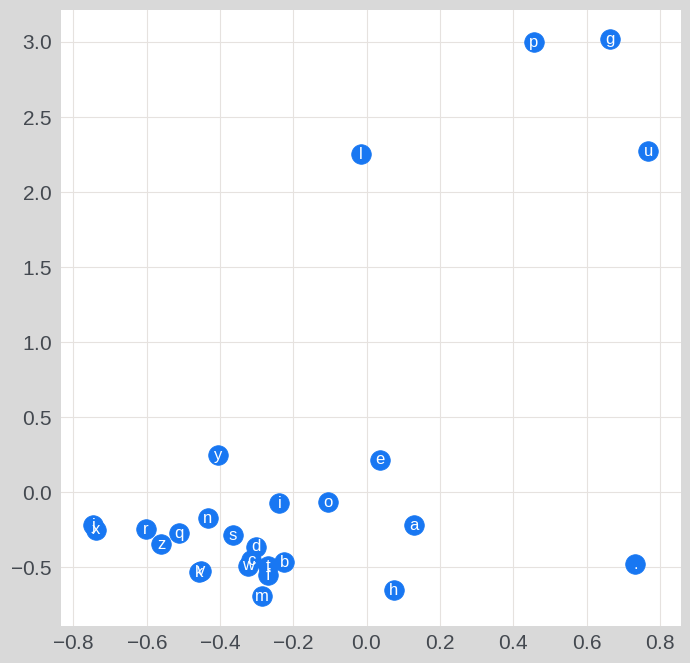

In [73]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), int_to_str[i], ha="center", va="center", color='white')
plt.grid('minor')
print("note that aeio are relative close to each other which means embedded layer treat them similar")
print("note that g are relative far away  which means embedded layer treat it completely different")
print('\n')

In [76]:
# sample from the model
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ w1 + b1)
      logits = h @ w2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(int_to_str[i] for i in out))

cariah.
amille.
khiimini.
eviy.
sacansie.
maciti.
mpeiriti.
aqei.
arienia.
ciriin.
kaleigh.
haminiin.
esinn.
sulioe.
cii.
biii.
jer.
giitrini.
cine.
pirsanley.
